# Análisis Exploratorio de Datos

En este notebook vamos a centrarnos en la exploración de las distintas variables que tenemos para predecir nuestra variable objetivo (Frio KW) y en el análisis de esta última. Todo esto con el fin de intentar detectar de forma temprana las posibles características que tengan mayor influencia en la predicción.

## 1. Exploración superficial de los crudos (.xlsx)

En este primer pantallazo no resulta interesante conocer un poco sobre qué información presenta cada hoja del archivo.

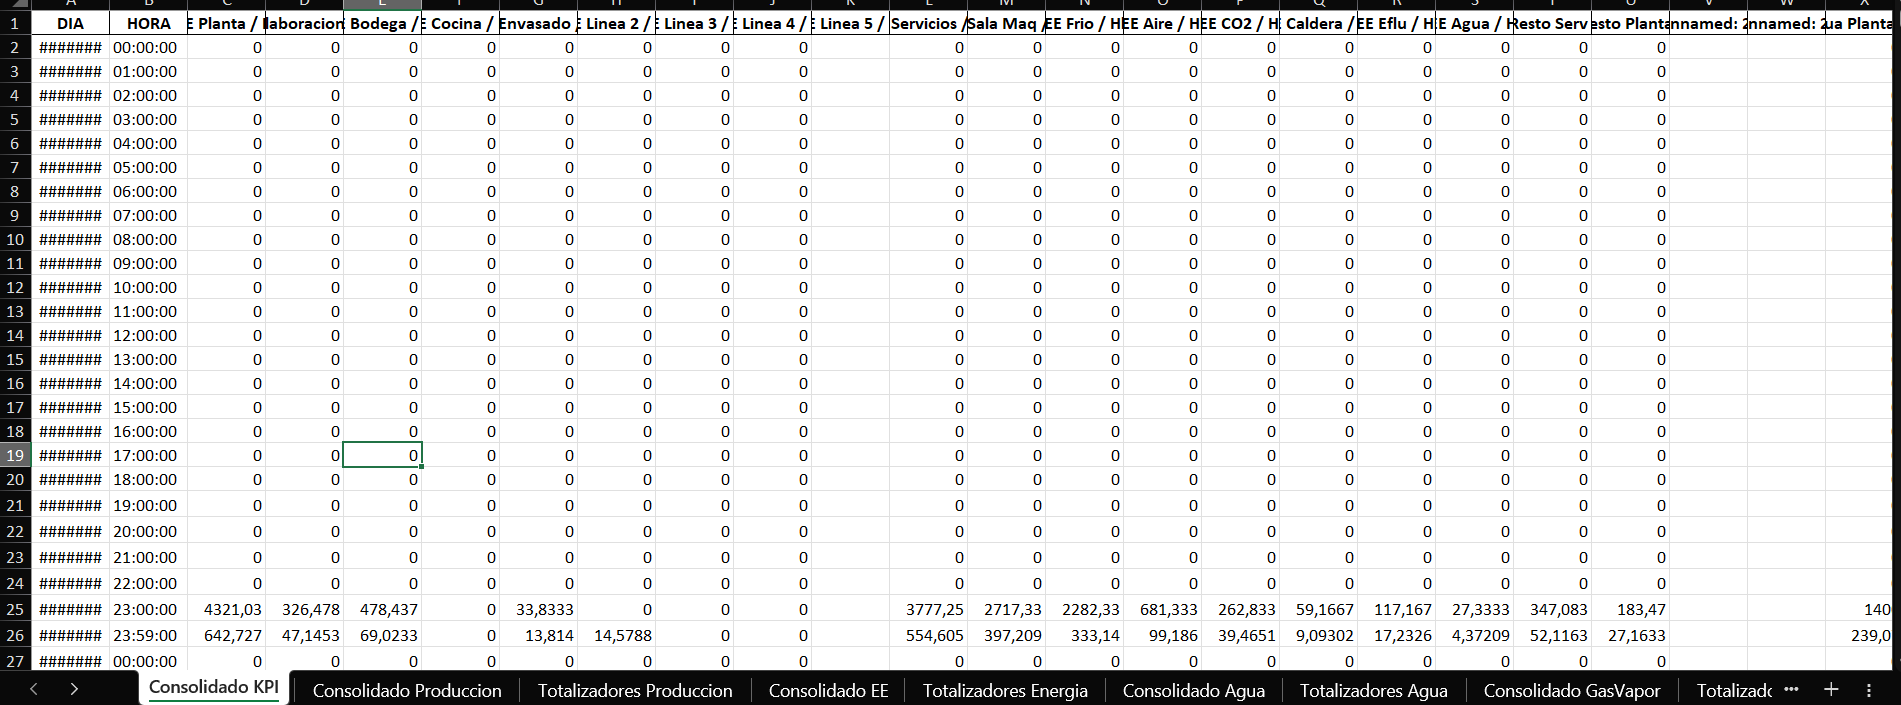

Mirando los nombres de las distintas hojas nos dimos cuenta que varias de ellas poseen 2 versiones:

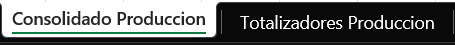

Lo que disparó la pregunta **¿Qué diferencia hay entre Consolidado y Totalizadores?**

Investigando un poco llegamos a la conclusión de que las hojas **Consolidado** son una especie de resumen filtrado y menos detallado de **Totalizadores**, esto normalmente se usa en las empresas para que gerentes o empleados que no están trabajando particularmente en la planta puedan ver los datos sin tanto ruido visual.

Esto ya nos lelvó a tomar una decisión. Siempre que sea posible (o sea, que exista) vamos a **usar la versión de Consolidado**.

Luego nos surgieron las típicas preguntas de: *"¿Qué significa esto? ¿Y esto otro?"*

Así que acá va un breve detalle de lo que significan algunas de las hojas:

- **KPI:** Son metricas de eficiencia creadas a partir de variables presentes en otras hojas.
- **Glicol:** Es el fluido refrigerante utilizado por el sistema de refrigeración.
- **Efluentes:** Son las aguas residuales de la planta. El proceso cervecero genera muchos residuos líquidos que deben ser tratados antes de ser descargados.
- **CO2:** Dióxido de carbono. En una cervecera, es crucial.

Una vez conocido lo que contienen nuestros crudos, pasamos a la siguiente etapa de decisión.

### ¿Qué vamos a extraer y por qué?

Para esto analizamos que más sencillo mirar lo que **NO** queríamos y el por qué, así que la decisión final fue lo siguiente:

Vamos a quedarnos con **todos los Consolidados** (justificado más arriba), y vamos a descartar las siguientes variables:

1. **KPI:** Al estar constituida por información de otras hojas existe la posibilidad de estar usando el *target para predecir el target*, o sea, ¡DATA LEAKAGE!
2. **Efluentes:** La hoja Consolidado EE ya tiene Efluentes (Kw) (la energía usada para tratarlos) y al ser un predictor menos directo podría añadir "ruido".

Quedando nuestra *lista de extracción* de esta forma:
- Consolidado EE
- Consolidado Produccion
- Totalizadores Energia
- Consolidado Agua
- Consolidado GasVapor
- Consolidado Aire
- Totalizadores Glicol
- Totalizadores CO2

---